# 04. Ken French Data and Pandas DataReader

Pandas DataReader is a powerful tool that provides easy access to various financial data sources through a consistent API.
The [Ken French Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html), accessible through pandas_datareader, offers a comprehensive collection of:

 - Historical stock returns organized into various portfolios
 - Risk factors (like market, size, value, momentum)
 - Pre-calculated research datasets commonly used in empirical asset pricing

In this notebook, we'll explore how to access and use these datasets using pandas_datareader.

## Browsing the Data

First, let's see what datasets are available:


In [1]:
import warnings

import pandas as pd
from pandas_datareader.famafrench import get_available_datasets
import pandas_datareader.data as web

In [2]:
len(get_available_datasets())

297

In [3]:
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

For this short demo, let's focus on `25_Portfolios_OP_INV_5x5_daily`, which is a dataset of 25 portfolios of stocks 25 sorted based on Operating Profitability and Investment

Note that there are 3 that are very similar:

 - `25_Portfolios_OP_INV_5x5`
 - `25_Portfolios_OP_INV_5x5_Wout_Div`
 - `25_Portfolios_OP_INV_5x5_daily`

You can find more information these portfolios [here:](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/tw_5_ports_op_inv.html)



> **Univariate Sort Portfolios Formed on Investment**
>
> **Daily Returns**:	 	July 1, 1963 - November 30, 2024
>
> **Monthly Returns**:	 	July 1963 - November 2024
>
> **Annual Returns**:	 	1964 - 2023
>
> **Construction**:	 	The portfolios, which are constructed at the end of each June, are the intersections of 5 portfolios formed on profitability (OP) and 5 portfolios formed on investment (Inv). OP for June of year t is annual revenues minus cost of goods sold, interest expense, and selling, general, and administrative expenses divided by book equity for the last fiscal year end in t-1. The OP breakpoints are NYSE quintiles. Investment is the change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets. The Inv breakpoints are NYSE quintiles.
> 	 	 
> Please be aware that some of the value-weight averages of operating profitability for deciles 1 and 10 are extreme. These are driven by extraordinary values of OP for individual firms. We have spot checked the accounting data that produce the extraordinary values and all the numbers we examined accurately reflect the data in the firm's accounting statements.
> 	 	 
>**Stocks**:	 	The portfolios for July of year t to June of t+1 include all NYSE, AMEX, and NASDAQ stocks for which we have (positive) BE for t-1, total assets data for t-2 and t-1, non-missing revenues data for t-1, and non-missing data for at least one of the following: cost of goods sold, selling, general and administrative expenses, or interest expense for t-1.


## DISCUSSION: Why characteristic-based portfolios?

Suppose I thought that stocks with, say, high operating profitability and low investment are more likely to be undervalued. Why would I be interested in forming _portfolios_ based off of this characteristic rather just choose 1 or two stocks of companies that have high operating profitability and low investment?

 - Testing theories?
 - Diversification?

## Accessing the Data

### Portfolio Sorts, Characteristic-Based Portfolios

In [4]:
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="The argument 'date_parser' is deprecated",
    )
    ds = web.DataReader('25_Portfolios_OP_INV_5x5_daily', 'famafrench')


In [5]:
ds.keys()

dict_keys([0, 1, 2, 3, 'DESCR'])

In [6]:
ds

{0:             LoOP LoINV  OP1 INV2  OP1 INV3  OP1 INV4  LoOP HiINV  OP2 INV1  \
 Date                                                                         
 2020-02-10        0.92      0.66      0.09      1.36        1.36      0.70   
 2020-02-11        0.49      0.66      0.07      0.62        0.14      1.20   
 2020-02-12        0.58      0.37     -0.06      0.38        1.39      0.48   
 2020-02-13       -1.03     -0.80     -0.30      0.25        0.25      0.02   
 2020-02-14       -0.28     -0.64      0.45      0.04        0.59     -0.16   
 ...                ...       ...       ...       ...         ...       ...   
 2024-12-24        0.98      0.94      0.47      0.96        1.70      0.94   
 2024-12-26        1.49      0.14     -0.33      0.20        0.08      0.32   
 2024-12-27       -1.80     -0.72     -1.40     -1.44       -2.26     -0.68   
 2024-12-30       -1.16     -1.85     -1.08     -1.42       -1.90     -0.96   
 2024-12-31       -0.31     -0.65     -0.32     -

In [7]:
print(ds["DESCR"])


25 Portfolios OP INV 5x5 daily
------------------------------

This file was created by CMPT_ME_BEME_OP_INV_RETS_DAILY using the 202412 CRSP database. It contains value- and equal-weighted returns for portfolios formed on OP and INV. The portfolios are constructed at the end of June. OP is operating profits (sales - cost of goods sold - selling, general and administrative expenses - interest expense) divided by book at the last fiscal year end of the prior calendar year. INV is the change in total assets from the fiscal year ending in year t-2 to the fiscal year ending in t-1, divided by t-2 total assets. Annual returns are from January to December. Missing data are indicated by -99.99 or -999. Please be aware that some of the value-weight averages of operating profitability for deciles 1 and 10 are extreme. These are driven by extraordinary values of OP for individual firms. We have spot checked the accounting data that produce the extraordinary values and all the numbers we examined 

In [8]:
ds[0].tail()

,LoOP LoINV,OP1 INV2,OP1 INV3,OP1 INV4,LoOP HiINV,OP2 INV1,OP2 INV2,OP2 INV3,OP2 INV4,OP2 INV5,...,OP4 INV1,OP4 INV2,OP4 INV3,OP4 INV4,OP4 INV5,HiOP LoINV,OP5 INV2,OP5 INV3,OP5 INV4,HiOP HiINV
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-24,0.98,0.94,0.47,0.96,1.70,0.94,0.95,0.85,0.78,1.04,...,0.37,1.67,0.65,0.97,1.31,0.41,1.28,0.72,0.91,0.81
2024-12-26,1.49,0.14,-0.33,0.20,0.08,0.32,0.08,0.15,0.28,-0.11,...,-0.18,0.01,0.17,-0.07,-0.42,0.29,0.67,0.09,0.00,-0.18
2024-12-27,-1.80,-0.72,-1.40,-1.44,-2.26,-0.68,-0.54,-0.80,-0.92,-0.94,...,-1.96,-1.05,-0.42,-1.18,-1.06,-0.77,-1.15,-0.51,-0.62,-1.37
2024-12-30,-1.16,-1.85,-1.08,-1.42,-1.90,-0.96,-0.89,-0.92,-0.83,-1.03,...,0.25,-0.96,-0.80,-0.88,-1.11,-1.05,-1.49,-0.90,-0.91,-1.22
2024-12-31,-0.31,-0.65,-0.32,-0.30,-1.30,0.20,0.21,0.03,0.21,-0.24,...,-2.10,-0.15,0.66,-0.52,-0.71,0.25,-0.49,0.30,0.11,-0.47


In [9]:
ds[0].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1232 entries, 2020-02-10 to 2024-12-31
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LoOP LoINV  1232 non-null   float64
 1   OP1 INV2    1232 non-null   float64
 2   OP1 INV3    1232 non-null   float64
 3   OP1 INV4    1232 non-null   float64
 4   LoOP HiINV  1232 non-null   float64
 5   OP2 INV1    1232 non-null   float64
 6   OP2 INV2    1232 non-null   float64
 7   OP2 INV3    1232 non-null   float64
 8   OP2 INV4    1232 non-null   float64
 9   OP2 INV5    1232 non-null   float64
 10  OP3 INV1    1232 non-null   float64
 11  OP3 INV2    1232 non-null   float64
 12  OP3 INV3    1232 non-null   float64
 13  OP3 INV4    1232 non-null   float64
 14  OP3 INV5    1232 non-null   float64
 15  OP4 INV1    1232 non-null   float64
 16  OP4 INV2    1232 non-null   float64
 17  OP4 INV3    1232 non-null   float64
 18  OP4 INV4    1232 non-null   float64
 19  OP4 INV5 

### Benchmark Data

Let's also download some benchmark data.

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings(
        "ignore",
        category=FutureWarning,
        message="The argument 'date_parser' is deprecated",
    )
    dbs = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench')

dbs.keys()

dict_keys([0, 'DESCR'])

In [11]:
print(dbs["DESCR"])


F-F Research Data Factors daily
-------------------------------

This file was created by CMPT_ME_BEME_RETS_DAILY using the 202412 CRSP database. The Tbill return is the simple daily rate that, over the number of trading days compounds to 1-month TBill rate. The 1-month TBill rate data until 202405 are from Ibbotson Associates. Starting from 202406, the 1-month TBill rate is from ICE BofA US 1-Month Treasury Bill Index. Copyright 2024 Eugene F. Fama and Kenneth R. French

  0 : (1232 rows x 4 cols)


In [12]:
dbs[0].tail()


,Mkt-RF,SMB,HML,RF
Date,,,,
2024-12-24,1.11,-0.09,-0.05,0.017
2024-12-26,0.02,1.04,-0.19,0.017
2024-12-27,-1.17,-0.66,0.56,0.017
2024-12-30,-1.09,0.12,0.74,0.017
2024-12-31,-0.46,0.00,0.71,0.017


Note, based on the description provided, Ken French's 5x5 portfolios are formed using independent sorts, but with an important nuance:

1. The breakpoints (quintiles) for both Operating Profitability and Investment are determined using **NYSE stocks only**

2. However, the portfolios themselves include **all stocks** (NYSE, AMEX, and NASDAQ) that meet the data requirements

This methodology means:
- The breakpoints are not influenced by the typically smaller AMEX and NASDAQ stocks
- When all stocks are sorted into the portfolios using these NYSE-based breakpoints, the resulting portfolios will likely NOT have equal value weights
- This is intentional - it helps address issues with microcaps while still including the broader universe of stocks

This is different from what you described with median cuts where you might expect equal weights. The use of NYSE breakpoints but all-stock portfolios means some portfolios (especially those containing small NASDAQ stocks) might end up with more firms but smaller total market cap than others.

This methodology has become standard in the empirical asset pricing literature precisely because it handles the size-based peculiarities of the US stock market in a systematic way.


## Performance Analysis

Now, let's analyze the performance of one of these portfolios. Let's create a tear sheet for the portfolio.
A "tear sheet" is a comprehensive summary of portfolio performance that includes key metrics and visualizations. Common components include:
* Risk metrics (Sharpe ratio, maximum drawdown, Value at Risk)
* Return statistics (CAGR, monthly/annual returns, win rates)
* Risk-adjusted performance measures (Sortino ratio, Calmar ratio)
* Visual analytics (drawdown plots, return distributions, rolling statistics)

The [QuantStats package](https://github.com/ranaroussi/quantstats) is just a small, demo package that provides some quick analytics for use to work with. It combines statistical analysis with visualization capabilities, making it easy to create portfolio reports. The package can also generate HTML tear sheets that include a nice array of metrics and plots. In the future, you'll want to create your own customized code to create tear sheets. But, for now, let's use theirs.


Here's a simple example. 

First, let's create a dataframe with the portfolio returns and the benchmark returns.


In [13]:
portfolio_returns = ds[0][["HiOP LoINV"]]

In [14]:
portfolio_returns.tail()

,HiOP LoINV
Date,
2024-12-24,0.41
2024-12-26,0.29
2024-12-27,-0.77
2024-12-30,-1.05
2024-12-31,0.25


In [15]:
df = pd.concat([portfolio_returns, dbs[0]], axis=1)
df["Mkt"] = df["Mkt-RF"] + df["RF"]

# df.index = df.index.to_timestamp()

df = df/100
df.tail()



,HiOP LoINV,Mkt-RF,SMB,HML,RF,Mkt
Date,,,,,,
2024-12-24,0.0041,0.0111,-0.0009,-0.0005,0.00017,0.01127
2024-12-26,0.0029,0.0002,0.0104,-0.0019,0.00017,0.00037
2024-12-27,-0.0077,-0.0117,-0.0066,0.0056,0.00017,-0.01153
2024-12-30,-0.0105,-0.0109,0.0012,0.0074,0.00017,-0.01073
2024-12-31,0.0025,-0.0046,0.0000,0.0071,0.00017,-0.00443


                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2020-02-10   2020-02-10
End Period          2024-12-31   2024-12-31
Risk-Free Rate      0.01%        0.01%
Time in Market      100.0%       100.0%

Cumulative Return   87.29%       66.25%
CAGR﹪              9.26%        7.44%

Sharpe              0.69         0.57
Prob. Sharpe Ratio  93.41%       89.47%
Sortino             0.97         0.81
Sortino/√2          0.68         0.57
Omega               1.11         1.11

Max Drawdown        -34.27%      -29.32%
Longest DD Days     766          1039

Gain/Pain Ratio     0.14         0.11
Gain/Pain (1M)      0.77         0.54

Payoff Ratio        0.92         0.91
Profit Factor       1.14         1.11
Common Sense Ratio  1.07         1.11
CPC Index           0.57         0.55
Tail Ratio          0.94         1.0
Outlier Win Ratio   3.92         3.77
Outlier Loss Ratio  4.01         3.77

MTD                 -2.82%       -6.04%
3M         

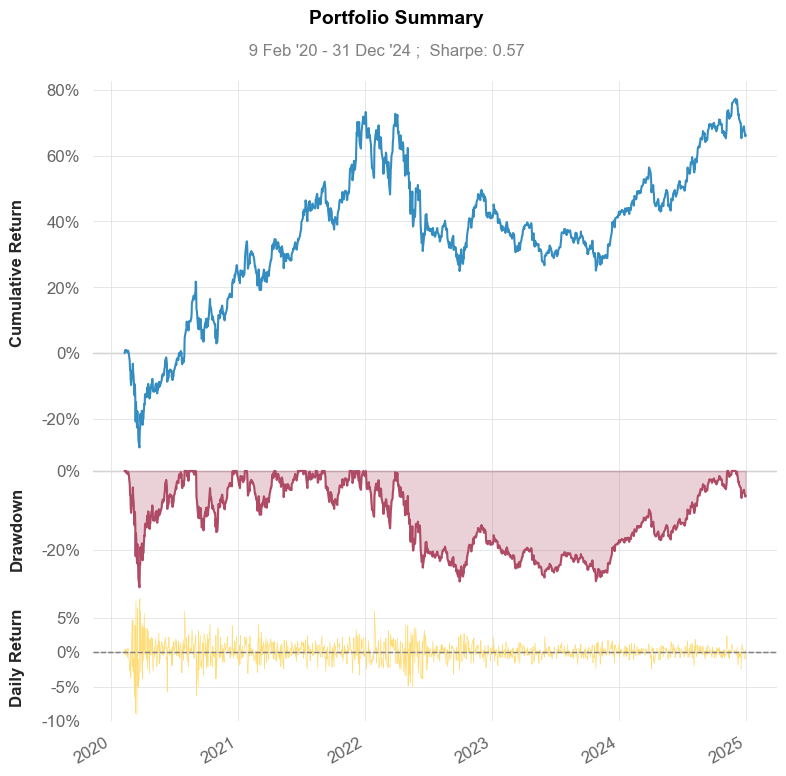

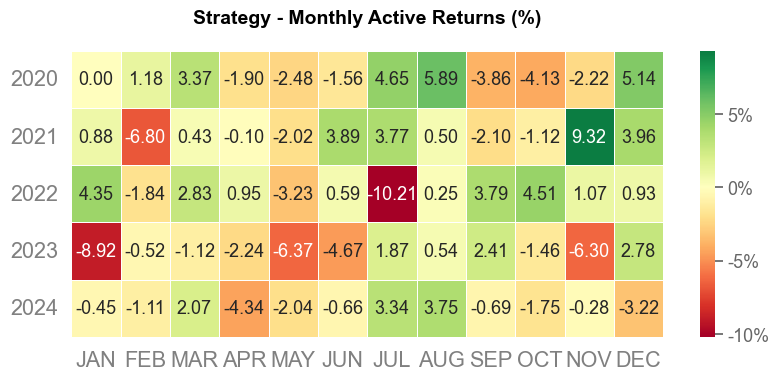

In [16]:
import quantstats as qs

# qs.extend_pandas()

# Generate HTML tear sheet comparing the portfolio to the S&P 500
qs.reports.basic(df["HiOP LoINV"], benchmark=df["Mkt"], rf=df["RF"].mean())


In [17]:
# qs.reports.full(df["HiOP LoINV"], benchmark=df["Mkt"], rf=df["RF"].mean())